In [1]:
#General Imports
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

2025-09-03 18:19:50.620970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756923590.820149      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756923590.877054      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
#one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

I0000 00:00:1756923619.241820      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False
# base_model.trainable = False

In [7]:
#Fully-connected layer
fine_tuning_model = models.Sequential([
    layers.Resizing(256, 256, input_shape=(32, 32, 3)),  # Resize CIFAR-10 (32x32) → 224x224
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

fine_tuning_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,899,018 (156.02 MB)

 Trainable params: 40,583,370 (154.81 MB)

 Non-trainable params: 315,648 (1.20 MB)

In [8]:
#Compile model
fine_tuning_model.compile(
    # optimizer= Adam(2e-5),
    optimizer = optimizers.RMSprop(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    # vertical_flip = True
)
datagen.fit(x_train)

In [10]:
#fit
history1 = fine_tuning_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data = (x_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1756923658.237620      59 service.cc:148] XLA service 0x7d2a100046a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756923658.238693      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756923661.610587      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756923681.741906      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 366s 199ms/step - accuracy: 0.3362 - loss: 2.0215 - val_accuracy: 0.8245 - val_loss: 0.6355
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 182ms/step - accuracy: 0.6932 - loss: 1.0172 - val_accuracy: 0.8959 - val_loss: 0.4101
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 182ms/step - accuracy: 0.8006 - loss: 0.7457 - val_accuracy: 0.9185 - val_loss: 0.2989
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 182ms/step - accuracy: 0.8462 - loss: 0.6118 - val_accuracy: 0.9367 - val_loss: 0.2436
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 182ms/step - accuracy: 0.8763 - loss: 0.5135 - val_accuracy: 0.9437 - val_loss: 0.2008
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 182ms/step - accuracy: 0.8950 - loss: 0.4532 - val_accuracy: 0.9477 - val_loss: 0.1865
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 284s 182ms/step - accuracy: 0.9157 - loss: 0.3760 - val_accuracy: 0.9475 - val_loss: 0.1817
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 182ms/step - accuracy: 0.9

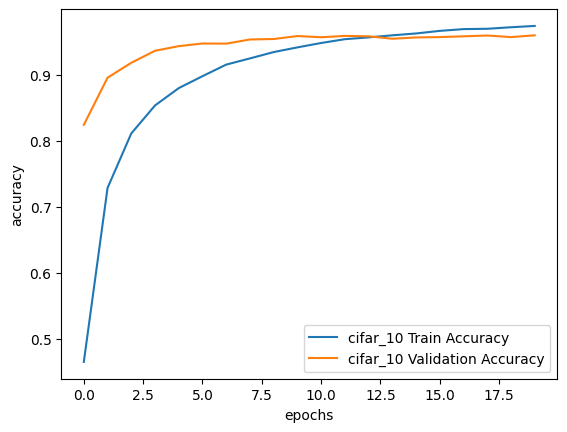

In [11]:
#plot the data
plt.plot(history1.history['accuracy'], label=f'{"cifar_10"} Train Accuracy')
plt.plot(history1.history['val_accuracy'], label=f'{"cifar_10"} Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [12]:
y_pred = fine_tuning_model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1) if y_test.ndim > 1 else y_test

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step
Test Accuracy: 96.01%


In [13]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.98      0.97      1000
           2       0.96      0.96      0.96      1000
           3       0.91      0.94      0.92      1000
           4       0.97      0.95      0.96      1000
           5       0.97      0.88      0.93      1000
           6       0.97      0.99      0.98      1000
           7       0.96      0.98      0.97      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [14]:
# save model
fine_tuning_model.save("resnet50_finetuned.keras")